##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Eight_Schools.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Eight schools

The eight schools problem ([Rubin 1981](https://www.jstor.org/stable/1164617)) considers the effectiveness of SAT coaching programs conducted in parallel at eight schools. It has become a classic problem ([Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), [Stan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)) that illustrates the usefulness of hierarchical modeling for sharing information between exchangeable groups.

The Edward2 implemention below is an adaptation of an Edward 1.0 [tutorial](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb).  

# Imports

In [2]:
!pip install -q tensorflow-probability

In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = True #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

In [2]:
def testZNoDepOnY(self):
 
  @function.Defun(tf.float32, tf.float32)
  def Foo(x, y):  # pylint: disable=unused-argument
    return x * 2
 
  with tf.Graph().as_default():
    # z = Foo(x, y). z doe
    x = tf.constant(1.0)
    y = tf.constant(2.0)
    z = Foo(x, y)
    dx, dy = tf.gradients([z], [x, y])
    with tf.Session() as sess:
      dx_val, dy_val = sess.run([dx, dy])
      self.assertEqual([2.0], dx_val)
      self.assertEqual([0.0], dy_val)

In [11]:

def f(x, y):
    return tf.reduce_sum(x, y)

f = tf.contrib.eager.defun(f, (tf.float32, tf.float32))
x = tf.constant(1.0)
y = tf.constant(2.0)
f(x, y)

TypeError: Invalid input_signature %s; input_signature must be a possibly nested sequence of TensorSpec objects.

In [13]:
def f(*args):
    return tf.reduce_sum(*args)

with pm.Model():
    x = tf.constant([[2.0, 3.0]])
    y = tf.constant([[3.0, -2.0]])
    z = tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

def Model.logp():
    logp_func = tf.contrib.eager.defun(f)
    return logp_func(*self.free_RVs)

<tf.Tensor: id=252, shape=(), dtype=float32, numpy=20.0>

In [17]:
def f(x, y, z):
  return z

g = tf.contrib.eager.defun(f)

x = tf.constant([[2.0, 5.0]])
y = tf.constant([[3.0, -2.0]])
z = tf.reduce_mean(tf.multiply(x ** 2, 3) + y)
print(g(x, y, z))

x = tf.constant([[2.0, 10.0]])
y = tf.constant([[3.0, -2.0]])
print(g(x, y, z))

tf.Tensor(44.0, shape=(), dtype=float32)
tf.Tensor(44.0, shape=(), dtype=float32)


In [3]:
import tensorflow as tf

tf.enable_eager_execution()

# A simple example.
def f(x, y):
  return tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

g = tf.contrib.eager.defun(f)

x = tf.constant([[2.0, 3.0]])
y = tf.constant([[3.0, -2.0]])

# `f` and `g` will return the same value, but `g` will be executed as a
# TensorFlow graph.
assert f(x, y).numpy() == g(x, y).numpy()

# `defun` is capable of compiling Python functions that close over Python
# objects, including Tensors and Variables.
@tf.contrib.eager.defun
def h():
  return f(x, y)

assert (h().numpy() == f(x, y).numpy()).all()

# `defun` automatically lifts variables out of the graphs it creates,
# allowing you to compile the `call` methods of <a href="../../../tf/keras/layers/Layer"><code>tf.keras.layers.Layer</code></a> and
# <a href="../../../tf/keras/models/Model"><code>tf.keras.Model</code></a> objects.
class MyModel(tf.keras.Model):

  def __init__(self, keep_probability=0.2):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    self.keep_probability = keep_probability

  @tf.contrib.eager.defun
  def call(self, inputs, training=True):
    x = self.dense2(self.dense1(inputs))
    if training:
      return tf.nn.dropout(x, self.keep_probability)
    else:
      return x

model = MyModel()
model(x, training=True)  # executes a graph, with dropout
model(x, training=False) # executes a graph, without dropout

# `defun`-compiled functions are differentiable.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
with tf.GradientTape() as tape:
  outputs = model(x)
gradient = tape.gradient(outputs, model.trainable_variables)
optimizer.apply_gradients((grad, var) for grad, var in zip(gradient,
                          model.trainable_variables))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

# The Data

From Bayesian Data Analysis, section 5.5 (Gelman et al. 2013):

> *A study was performed for the Educational Testing Service to analyze the effects of special coaching programs for SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be very successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.*


For each of the eight schools ($J = 8$), we have an estimated treatment effect $y_j$ and a standard error of the effect estimate $\sigma_j$. The treatment effects in the study were obtained by a linear regression on the treatment group using PSAT-M and PSAT-V scores as control variables. As there was no prior belief that any of the schools were more or less similar or that any of the coaching programs would be more effective, we can consider the treatment effects as [exchangeable](https://en.wikipedia.org/wiki/Exchangeable_random_variables).

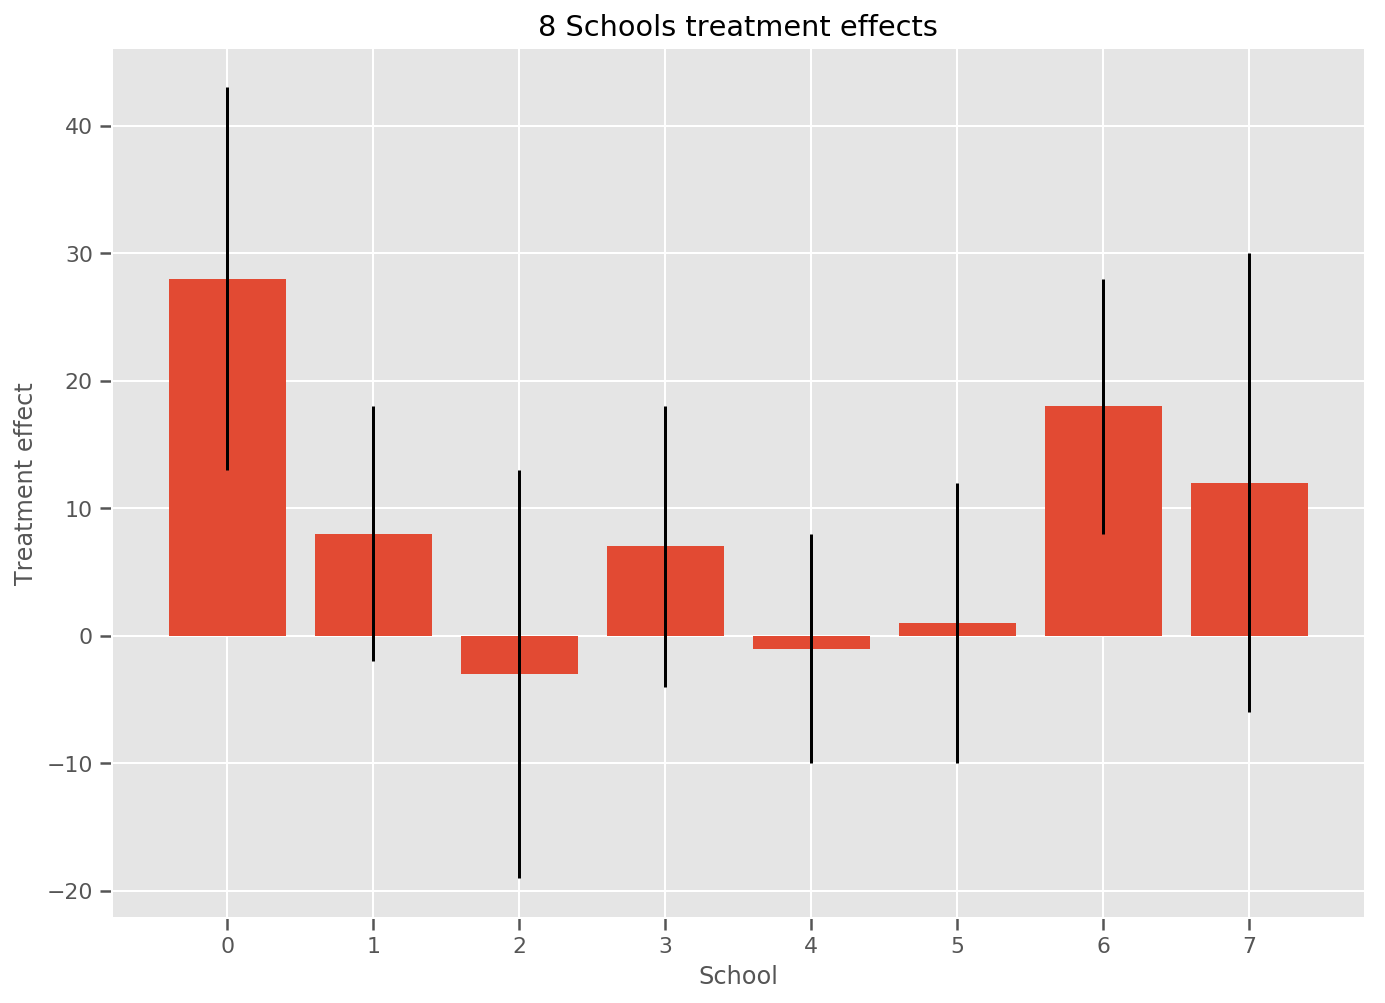

In [3]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

# Model

To capture the data, we use a hierarchical normal model. It follows the generative process,

\begin{align*}
\mu &\sim \text{Normal}(\text{loc}{=}0,\ \text{scale}{=}10) \\
\log\tau &\sim \text{Normal}(\text{loc}{=}5,\ \text{scale}{=}1) \\
\text{for } & i=1\ldots 8:\\
& \theta_i \sim \text{Normal}\left(\text{loc}{=}\mu,\ \text{scale}{=}\tau \right) \\
& y_i \sim \text{Normal}\left(\text{loc}{=}\theta_i,\ \text{scale}{=}\sigma_i \right) 
\end{align*}

where $\mu$ represents the prior average treatment effect and $\tau$ controls how much variance there is between schools. The $y_i$ and $\sigma_i$ are observed. As $\tau \rightarrow \infty$, the model approaches the no-pooling model, i.e., each of the school treatment effect estimates are allowed to be more independent. As $\tau \rightarrow 0$, the model approaches the complete-pooling model, i.e., all of the school treatment effects are closer to the group average $\mu$. To restrict the standard deviation to be positive, we draw $\tau$ from a lognormal distribution (which is equivalent to drawing $log(\tau)$ from a normal distribution).

Following [Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html), we transform the model above into an equivalent non-centered model:

\begin{align*}
\mu &\sim \text{Normal}(\text{loc}{=}0,\ \text{scale}{=}10) \\
\log\tau &\sim \text{Normal}(\text{loc}{=}5,\ \text{scale}{=}1) \\
\text{for } & i=1\ldots 8:\\
& \theta_i' \sim \text{Normal}\left(\text{loc}{=}0,\ \text{scale}{=}1 \right) \\
& \theta_i = \mu + \tau \theta_i' \\
& y_i \sim \text{Normal}\left(\text{loc}{=}\theta_i,\ \text{scale}{=}\sigma_i \right) 
\end{align*}

We reify this model as an Edward2 program:

In [4]:
def schools_model(num_schools, treatment_stddevs):
  avg_effect = ed.Normal(loc=0., scale=10., name="avg_effect")  # `mu` above
  avg_stddev = ed.Normal(
      loc=5., scale=1., name="avg_stddev")  # `log(tau)` above
  school_effects_standard = ed.Normal(
      loc=tf.zeros(num_schools),
      scale=tf.ones(num_schools),
      name="school_effects_standard")  # `theta_prime` above
  school_effects = avg_effect + tf.exp(
      avg_stddev) * school_effects_standard  # `theta` above
  treatment_effects = ed.Normal(
      loc=school_effects, scale=treatment_stddevs,
      name="treatment_effects")  # `y` above
  return treatment_effects

log_joint = ed.make_log_joint_fn(schools_model)


def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return log_joint(
      num_schools=num_schools,
      treatment_stddevs=treatment_stddevs,
      avg_effect=avg_effect,
      avg_stddev=avg_stddev,
      school_effects_standard=school_effects_standard,
      treatment_effects=treatment_effects)

# Bayesian Inference

Given data, we perform Hamiltonian Monte Carlo (HMC) to calculate the posterior distribution over the model's parameters.

In [5]:
num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.zeros([], name='init_avg_effect'),
        tf.zeros([], name='init_avg_stddev'),
        tf.ones([num_schools], name='init_school_effects_standard'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.4,
        num_leapfrog_steps=3))

avg_effect, avg_stddev, school_effects_standard = states

with tf.Session() as sess:
  [
      avg_effect_,
      avg_stddev_,
      school_effects_standard_,
      is_accepted_,
  ] = sess.run([
      avg_effect,
      avg_stddev,
      school_effects_standard,
      kernel_results.is_accepted,
  ])

school_effects_samples = (
    avg_effect_[:, np.newaxis] +
    np.exp(avg_stddev_)[:, np.newaxis] * school_effects_standard_)
num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [6]:
# Copyright 2018 The TensorFlow Probability Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""No U-Turn Sampler via an Eager-only single-chain implementation.
The implementation uses minimal abstractions and data structures: it applies
Python callables, lists, and Tensors. It closely follows [1; Algorithm 3] in
that there exists a "build tree" function that recursively builds the No-U-Turn
Sampler trajectory. The path length is set adaptively; the step size is fixed.
Future work may abstract this code as part of a Markov chain Monte Carlo
library.
#### References
[1]: Matthew D. Hoffman, Andrew Gelman. The No-U-Turn Sampler: Adaptively
     Setting Path Lengths in Hamiltonian Monte Carlo.
     In _Journal of Machine Learning Research_, 15(1):1593-1623, 2014.
     http://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfe = tf.contrib.eager

__all__ = [
    "kernel",
]


def kernel(target_log_prob_fn,
           current_state,
           step_size,
           seed=None,
           current_target_log_prob=None,
           current_grads_target_log_prob=None,
           name=None):
  """Simulates a No-U-Turn Sampler (NUTS) trajectory.
  Args:
    target_log_prob_fn: Python callable which takes an argument like
      `*current_state` and returns its (possibly unnormalized) log-density under
      the target distribution.
    current_state: List of `Tensor`s representing the states to simulate from.
    step_size: List of `Tensor`s representing the step sizes for the leapfrog
      integrator. Must have same shape as `current_state`.
    seed: Integer to seed the random number generator.
    current_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `current_state`.
    current_grads_target_log_prob: List of `Tensor`s representing gradient of
      `current_target_log_prob` with respect to `current_state`. Must have same
      shape as `current_state`.
    name: A name for the operation.
  Returns:
    next_state: List of `Tensor`s representing the next states of the NUTS
      trajectory. Has same shape as `current_state`.
    next_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at `next_state`.
    next_grads_target_log_prob: List of `Tensor`s representing the gradient of
      `next_target_log_prob` with respect to `next_state`.
  Raises:
    NotImplementedError: If the execution mode is not eager.
  """
  if not tf.executing_eagerly():
    raise NotImplementedError("`kernel` is only available in Eager mode.")

  with tf.name_scope(name,
                     default_name="nuts_kernel",
                     values=[current_state, step_size, seed,
                             current_target_log_prob,
                             current_grads_target_log_prob]):
    with tf.name_scope("initialize"):
      current_state = [tf.convert_to_tensor(s) for s in current_state]
      step_size = [tf.convert_to_tensor(s) for s in step_size]
      value_and_gradients_fn = tfe.value_and_gradients_function(
          target_log_prob_fn)
      value_and_gradients_fn = _embed_no_none_gradient_check(
          value_and_gradients_fn)
      if (current_target_log_prob is None or
          current_grads_target_log_prob is None):
        (current_target_log_prob,
         current_grads_target_log_prob) = value_and_gradients_fn(*current_state)

      seed_stream = tfd.SeedStream(seed, "nuts_kernel")
      current_momentum = []
      for state_tensor in current_state:
        momentum_tensor = tf.random_normal(shape=tf.shape(state_tensor),
                                           dtype=state_tensor.dtype,
                                           seed=seed_stream())
        current_momentum.append(momentum_tensor)

      # Draw a slice variable u ~ Uniform(0, p(initial state, initial
      # momentum)) and compute log u. For numerical stability, we perform this
      # in log space where log u = log (u' * p(...)) = log u' + log
      # p(...) and u' ~ Uniform(0, 1).
      log_slice_sample = tf.log(tf.random_uniform([], seed=seed_stream()))
      log_slice_sample += _log_joint(current_target_log_prob,
                                     current_momentum)

      # Initialize loop variables. It comprises a collection of information
      # about a "reverse" state, a collection of information about a "forward"
      # state, a collection of information about the next state,
      # the trajectory's tree depth, the number of candidate states, and
      # whether to continue the trajectory.
      reverse_state = current_state
      reverse_target_log_prob = current_target_log_prob
      reverse_grads_target_log_prob = current_grads_target_log_prob
      reverse_momentum = current_momentum
      forward_state = current_state
      forward_target_log_prob = current_target_log_prob
      forward_grads_target_log_prob = current_grads_target_log_prob
      forward_momentum = current_momentum
      next_state = current_state
      next_target_log_prob = current_target_log_prob
      next_grads_target_log_prob = current_grads_target_log_prob
      depth = 0
      num_states = 1
      continue_trajectory = True

    while continue_trajectory:
      # Grow the No-U-Turn Sampler trajectory by choosing a random direction and
      # simulating Hamiltonian dynamics in that direction. This extends either
      # the forward or reverse state.
      direction = tfp.math.random_rademacher([], seed=seed_stream())
      if direction < 0:
        [
            reverse_state,
            reverse_target_log_prob,
            reverse_grads_target_log_prob,
            reverse_momentum,
            _,
            _,
            _,
            _,
            next_state_in_subtree,
            next_target_log_prob_in_subtree,
            next_grads_target_log_prob_in_subtree,
            num_states_in_subtree,
            continue_trajectory,
        ] = _build_tree(
            value_and_gradients_fn=value_and_gradients_fn,
            current_state=reverse_state,
            current_target_log_prob=reverse_target_log_prob,
            current_grads_target_log_prob=reverse_grads_target_log_prob,
            current_momentum=reverse_momentum,
            direction=direction,
            depth=depth,
            step_size=step_size,
            log_slice_sample=log_slice_sample,
            seed=seed_stream())
      else:
        [
            _,
            _,
            _,
            _,
            forward_state,
            forward_target_log_prob,
            forward_grads_target_log_prob,
            forward_momentum,
            next_state_in_subtree,
            next_target_log_prob_in_subtree,
            next_grads_target_log_prob_in_subtree,
            num_states_in_subtree,
            continue_trajectory,
        ] = _build_tree(
            value_and_gradients_fn=value_and_gradients_fn,
            current_state=forward_state,
            current_target_log_prob=forward_target_log_prob,
            current_grads_target_log_prob=forward_grads_target_log_prob,
            current_momentum=forward_momentum,
            direction=direction,
            depth=depth,
            step_size=step_size,
            log_slice_sample=log_slice_sample,
            seed=seed_stream())

      if continue_trajectory:
        # If the built tree did not terminate, accept the tree's next state
        # with a certain probability.
        accept_state_in_subtree = _random_bernoulli(
            [],
            probs=tf.minimum(1., num_states_in_subtree / num_states),
            dtype=tf.bool,
            seed=seed_stream())
        if accept_state_in_subtree:
          next_state = next_state_in_subtree
          next_target_log_prob = next_target_log_prob_in_subtree
          next_grads_target_log_prob = next_grads_target_log_prob_in_subtree

      # Continue the NUTS trajectory if the tree-building did not terminate, and
      # if the reverse-most and forward-most states do not exhibit a U-turn.
      has_no_u_turn = tf.logical_and(
          _has_no_u_turn(forward_state, reverse_state, forward_momentum),
          _has_no_u_turn(forward_state, reverse_state, reverse_momentum))
      continue_trajectory = continue_trajectory and has_no_u_turn
      num_states += num_states_in_subtree
      depth += 1

    return next_state, next_target_log_prob, next_grads_target_log_prob


def _build_tree(value_and_gradients_fn,
                current_state,
                current_target_log_prob,
                current_grads_target_log_prob,
                current_momentum,
                direction,
                depth,
                step_size,
                log_slice_sample,
                max_simulation_error=1000.,
                seed=None):
  """Builds a tree at a given tree depth and at a given state.
  The `current` state is immediately adjacent to, but outside of,
  the subtrajectory spanned by the returned `forward` and `reverse` states.
  Args:
    value_and_gradients_fn: Python callable which takes an argument like
      `*current_state` and returns a tuple of its (possibly unnormalized)
      log-density under the target distribution and its gradient with respect to
      each state.
    current_state: List of `Tensor`s representing the current states of the
      NUTS trajectory.
    current_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `current_state`.
    current_grads_target_log_prob: List of `Tensor`s representing gradient of
      `current_target_log_prob` with respect to `current_state`. Must have same
      shape as `current_state`.
    current_momentum: List of `Tensor`s representing the momentums of
      `current_state`. Must have same shape as `current_state`.
    direction: int that is either -1 or 1. It determines whether to perform
      leapfrog integration backwards (reverse) or forward in time respectively.
    depth: non-negative int that indicates how deep of a tree to build.
      Each call to `_build_tree` takes `2**depth` leapfrog steps.
    step_size: List of `Tensor`s representing the step sizes for the leapfrog
      integrator. Must have same shape as `current_state`.
    log_slice_sample: The log of an auxiliary slice variable. It is used
      together with `max_simulation_error` to avoid simulating trajectories with
      too much numerical error.
    max_simulation_error: Maximum simulation error to tolerate before
      terminating the trajectory. Simulation error is the
      `log_slice_sample` minus the log-joint probability at the simulated state.
    seed: Integer to seed the random number generator.
  Returns:
    reverse_state: List of `Tensor`s representing the "reverse" states of the
      NUTS trajectory. Has same shape as `current_state`.
    reverse_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `reverse_state`.
    reverse_grads_target_log_prob: List of `Tensor`s representing gradient of
      `reverse_target_log_prob` with respect to `reverse_state`. Has same shape
      as `reverse_state`.
    reverse_momentum: List of `Tensor`s representing the momentums of
      `reverse_state`. Has same shape as `reverse_state`.
    forward_state: List of `Tensor`s representing the "forward" states of the
      NUTS trajectory. Has same shape as `current_state`.
    forward_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at the `forward_state`.
    forward_grads_target_log_prob: List of `Tensor`s representing gradient of
      `forward_target_log_prob` with respect to `forward_state`. Has same shape
      as `forward_state`.
    forward_momentum: List of `Tensor`s representing the momentums of
      `forward_state`. Has same shape as `forward_state`.
    next_state: List of `Tensor`s representing the next states of the NUTS
      trajectory. Has same shape as `current_state`.
    next_target_log_prob: Scalar `Tensor` representing the value of
      `target_log_prob_fn` at `next_state`.
    next_grads_target_log_prob: List of `Tensor`s representing the gradient of
      `next_target_log_prob` with respect to `next_state`.
    num_states: Number of acceptable candidate states in the subtree. A state is
      acceptable if it is "in the slice", that is, if its log-joint probability
      with its momentum is greater than `log_slice_sample`.
    continue_trajectory: bool determining whether to continue the simulation
      trajectory. The trajectory is continued if no U-turns are encountered
      within the built subtree, and if the log-probability accumulation due to
      integration error does not exceed `max_simulation_error`.
  """
  if depth == 0:  # base case
    # Take a leapfrog step. Terminate the tree-building if the simulation
    # error from the leapfrog integrator is too large. States discovered by
    # continuing the simulation are likely to have very low probability.
    [
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        next_momentum,
    ] = _leapfrog(
        value_and_gradients_fn=value_and_gradients_fn,
        current_state=current_state,
        current_grads_target_log_prob=current_grads_target_log_prob,
        current_momentum=current_momentum,
        step_size=direction * step_size)
    next_log_joint = _log_joint(next_target_log_prob, next_momentum)
    num_states = tf.cast(next_log_joint > log_slice_sample, dtype=tf.int32)
    continue_trajectory = (next_log_joint >
                           log_slice_sample - max_simulation_error)
    return [
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        next_momentum,
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        next_momentum,
        next_state,
        next_target_log_prob,
        next_grads_target_log_prob,
        num_states,
        continue_trajectory,
    ]

  # Build a tree at the current state.
  seed_stream = tfd.SeedStream(seed, "build_tree")
  [
      reverse_state,
      reverse_target_log_prob,
      reverse_grads_target_log_prob,
      reverse_momentum,
      forward_state,
      forward_target_log_prob,
      forward_grads_target_log_prob,
      forward_momentum,
      next_state,
      next_target_log_prob,
      next_grads_target_log_prob,
      num_states,
      continue_trajectory,
  ] = _build_tree(value_and_gradients_fn=value_and_gradients_fn,
                  current_state=current_state,
                  current_target_log_prob=current_target_log_prob,
                  current_grads_target_log_prob=current_grads_target_log_prob,
                  current_momentum=current_momentum,
                  direction=direction,
                  depth=depth - 1,
                  step_size=step_size,
                  log_slice_sample=log_slice_sample,
                  seed=seed_stream())
  if continue_trajectory:
    # If the just-built subtree did not terminate, build a second subtree at
    # the forward or reverse state, as appropriate.
    if direction < 0:
      [
          reverse_state,
          reverse_target_log_prob,
          reverse_grads_target_log_prob,
          reverse_momentum,
          _,
          _,
          _,
          _,
          far_state,
          far_target_log_prob,
          far_grads_target_log_prob,
          far_num_states,
          far_continue_trajectory,
      ] = _build_tree(
          value_and_gradients_fn=value_and_gradients_fn,
          current_state=reverse_state,
          current_target_log_prob=reverse_target_log_prob,
          current_grads_target_log_prob=reverse_grads_target_log_prob,
          current_momentum=reverse_momentum,
          direction=direction,
          depth=depth - 1,
          step_size=step_size,
          log_slice_sample=log_slice_sample,
          seed=seed_stream())
    else:
      [
          _,
          _,
          _,
          _,
          forward_state,
          forward_target_log_prob,
          forward_grads_target_log_prob,
          forward_momentum,
          far_state,
          far_target_log_prob,
          far_grads_target_log_prob,
          far_num_states,
          far_continue_trajectory,
      ] = _build_tree(
          value_and_gradients_fn=value_and_gradients_fn,
          current_state=forward_state,
          current_target_log_prob=forward_target_log_prob,
          current_grads_target_log_prob=forward_grads_target_log_prob,
          current_momentum=forward_momentum,
          direction=direction,
          depth=depth - 1,
          step_size=step_size,
          log_slice_sample=log_slice_sample,
          seed=seed_stream())

    # Propose either `next_state` (which came from the first subtree and so is
    # nearby) or the new forward/reverse state (which came from the second
    # subtree and so is far away).
    num_states += far_num_states
    accept_far_state = _random_bernoulli(
        [],
        probs=far_num_states / num_states,
        dtype=tf.bool,
        seed=seed_stream())
    if accept_far_state:
      next_state = far_state
      next_target_log_prob = far_target_log_prob
      next_grads_target_log_prob = far_grads_target_log_prob

    # Continue the NUTS trajectory if the far subtree did not terminate either,
    # and if the reverse-most and forward-most states do not exhibit a U-turn.
    has_no_u_turn = tf.logical_and(
        _has_no_u_turn(forward_state, reverse_state, forward_momentum),
        _has_no_u_turn(forward_state, reverse_state, reverse_momentum))
    continue_trajectory = far_continue_trajectory and has_no_u_turn

  return [
      reverse_state,
      reverse_target_log_prob,
      reverse_grads_target_log_prob,
      reverse_momentum,
      forward_state,
      forward_target_log_prob,
      forward_grads_target_log_prob,
      forward_momentum,
      next_state,
      next_target_log_prob,
      next_grads_target_log_prob,
      num_states,
      continue_trajectory,
  ]


def _embed_no_none_gradient_check(value_and_gradients_fn):
  """Wraps value and gradients function to assist with None gradients."""
  @functools.wraps(value_and_gradients_fn)
  def func_wrapped(*args, **kwargs):
    """Wrapped function which checks for None gradients."""
    value, grads = value_and_gradients_fn(*args, **kwargs)
    if any(grad is None for grad in grads):
      raise ValueError("Gradient is None for a state.")
    return value, grads
  return func_wrapped


def _has_no_u_turn(state_one, state_two, momentum):
  """If two given states and momentum do not exhibit a U-turn pattern."""
  dot_product = sum([tf.reduce_sum((s1 - s2) * m)
                     for s1, s2, m in zip(state_one, state_two, momentum)])
  return dot_product > 0


def _leapfrog(value_and_gradients_fn,
              current_state,
              current_grads_target_log_prob,
              current_momentum,
              step_size):
  """Runs one step of leapfrog integration."""
  mid_momentum = [
      m + 0.5 * step * g for m, step, g in
      zip(current_momentum, step_size, current_grads_target_log_prob)]
  next_state = [
      s + step * m for s, step, m in
      zip(current_state, step_size, mid_momentum)]
  next_target_log_prob, next_grads_target_log_prob = value_and_gradients_fn(
      *next_state)
  next_momentum = [
      m + 0.5 * step * g for m, step, g in
      zip(mid_momentum, step_size, next_grads_target_log_prob)]
  return [
      next_state,
      next_target_log_prob,
      next_grads_target_log_prob,
      next_momentum,
  ]


def _log_joint(current_target_log_prob, current_momentum):
  """Log-joint probability given a state's log-probability and momentum."""
  momentum_log_prob = -sum([tf.reduce_sum(0.5 * (m ** 2.))
                            for m in current_momentum])
  return current_target_log_prob + momentum_log_prob


def _random_bernoulli(shape, probs, dtype=tf.int32, seed=None, name=None):
  """Returns samples from a Bernoulli distribution."""
  with tf.name_scope(name, "random_bernoulli", [shape, probs]):
    probs = tf.convert_to_tensor(probs)
    random_uniform = tf.random_uniform(shape, dtype=probs.dtype, seed=seed)
    return tf.cast(tf.less(random_uniform, probs), dtype)

In [13]:
num_results = 5000
num_burnin_steps = 3000


next_state, next_target_log_prob, next_grads_target_log_prob = kernel(
    target_log_prob_fn,
    [
        tf.zeros([], name='init_avg_effect'),
        tf.zeros([], name='init_avg_stddev'),
        tf.ones([num_schools], name='init_school_effects_standard'),
    ],
    [0.4] * (2 + num_schools))

avg_effect, avg_stddev, school_effects_standard = states

with tf.Session() as sess:
  [
      avg_effect_,
      avg_stddev_,
      school_effects_standard_,
      is_accepted_,
  ] = sess.run([
      avg_effect,
      avg_stddev,
      school_effects_standard,
      kernel_results.is_accepted,
  ])

school_effects_samples = (
    avg_effect_[:, np.newaxis] +
    np.exp(avg_stddev_)[:, np.newaxis] * school_effects_standard_)
num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

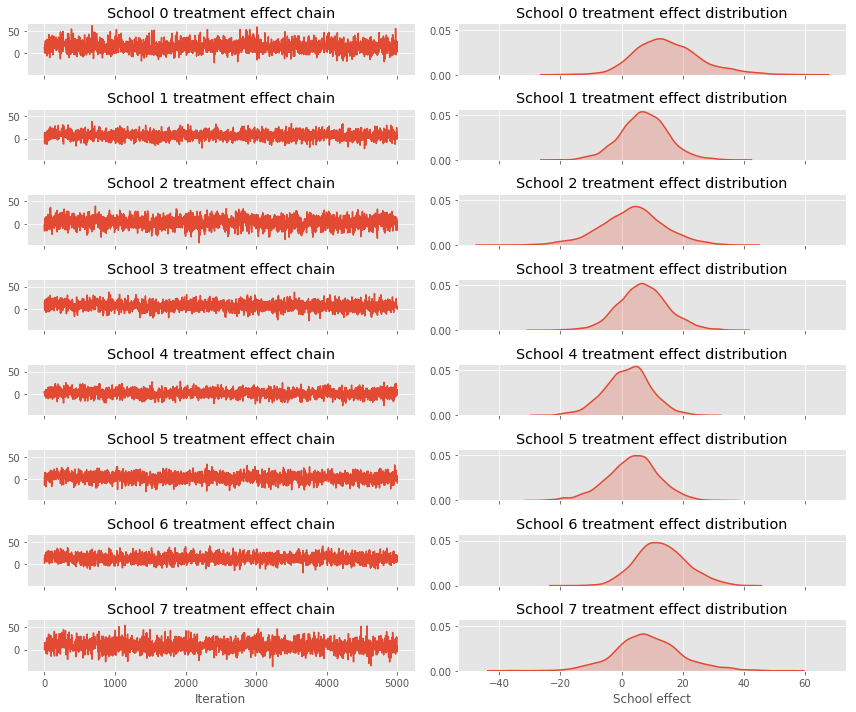

In [7]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [8]:
print("E[avg_effect] = {}".format(avg_effect_.mean()))
print("E[avg_stddev] = {}".format(avg_stddev_.mean()))
print("E[school_effects_standard] =")
print(school_effects_standard_[:, ].mean(0))
print("E[school_effects] =")
print(school_effects_samples[:, ].mean(0))

E[avg_effect] = 7.251519680023193
E[avg_stddev] = 2.430911064147949
E[school_effects_standard] =
[ 0.6078252   0.02697459 -0.2764748  -0.0134781  -0.41525856 -0.2700513
  0.49003458  0.1185067 ]
E[school_effects] =
[15.225814   7.4193077  3.6412437  7.1314797  2.1245272  3.724818
 13.075635   8.771215 ]


In [9]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

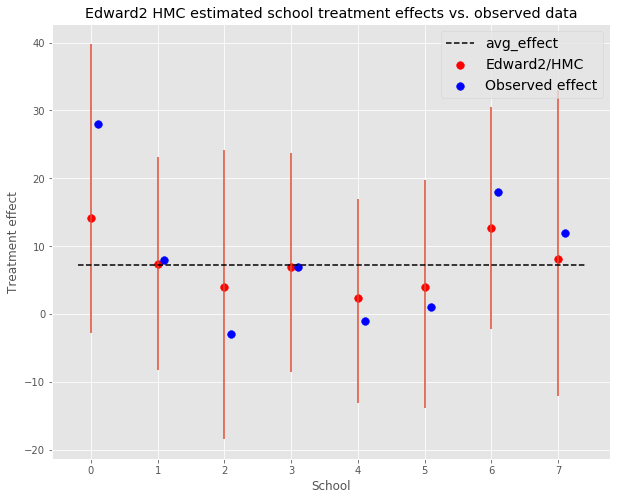

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

avg_effect = avg_effect_.mean()

plt.plot([-0.2, 7.4], [avg_effect, avg_effect], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'Edward2/HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('Edward2 HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

We can observe the shrinkage toward the group `avg_effect` above.

In [11]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(school_effects_samples[:,])))
print("Inferred posterior mean se: {0:.2f}".format(
    np.std(school_effects_samples[:,])))

Inferred posterior mean: 7.64
Inferred posterior mean se: 10.09


# Criticism

To get the posterior predictive distribution, i.e., a model of new data $y^*$ given the observed data $y$:

$$ p(y^*|y) \propto \int_\theta p(y^* | \theta)p(\theta |y)d\theta$$

we "intercept" the values of the random variables in the model to set them to the mean of the posterior distribution and sample from that model to generate new data $y^*$.

In [12]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
  """Replaces prior on effects with empirical posterior mean from MCMC."""
  name = rv_kwargs.pop("name")
  if name == "avg_effect":
    rv_kwargs["value"] = np.mean(avg_effect_, 0)
  elif name == "avg_stddev":
    rv_kwargs["value"] = np.mean(avg_stddev_, 0)
  elif name == "school_effects_standard":
    rv_kwargs["value"] = np.mean(school_effects_standard_, 0)
  return rv_constructor(*rv_args, **rv_kwargs)


with ed.interception(interceptor):
  posterior = schools_model(
      num_schools=num_schools, treatment_stddevs=treatment_stddevs)

with tf.Session() as sess:
  posterior_predictive = sess.run(
      posterior.distribution.sample(sample_shape=(5000)))

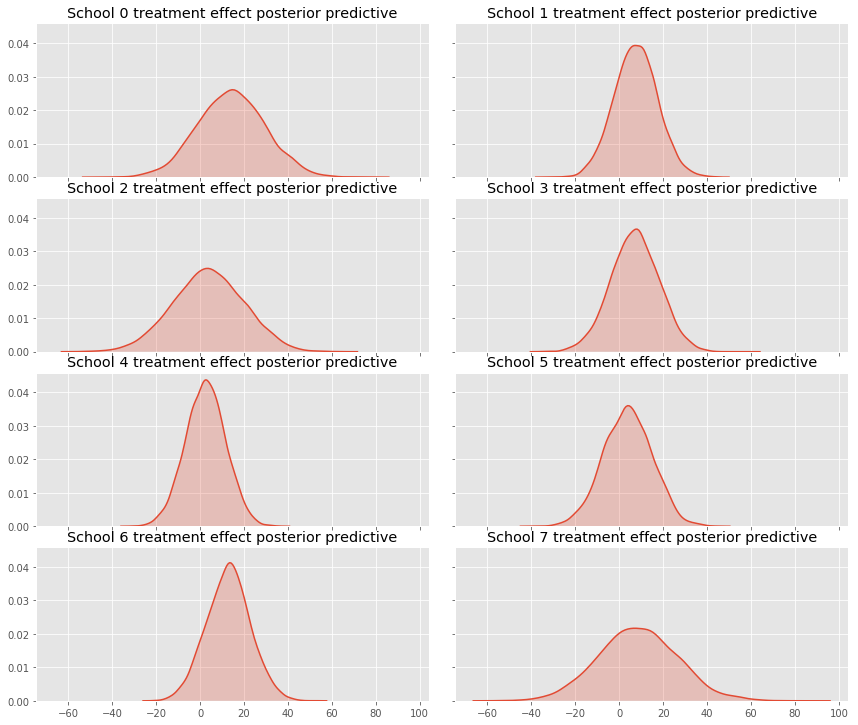

In [13]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(posterior_predictive[:, 2*i], ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i))
  sns.kdeplot(posterior_predictive[:, 2*i + 1], ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i + 1))
plt.show()

In [14]:
# The mean predicted treatment effects for each of the eight schools.
prediction = posterior_predictive.mean(axis=0)

We can look at the residuals between the treatment effects data and the predictions of the model posterior. These correspond with the plot above which shows the shrinkage of the estimated effects toward the population average.

In [15]:
treatment_effects - prediction

array([13.678436  ,  0.38133764, -6.852325  , -0.20191336, -3.5167577 ,
       -2.9342895 ,  5.121045  ,  3.3879137 ], dtype=float32)

Because we have a distribution of predictions for each school, we can consider the distribution of residuals as well.

In [16]:
residuals = treatment_effects - posterior_predictive

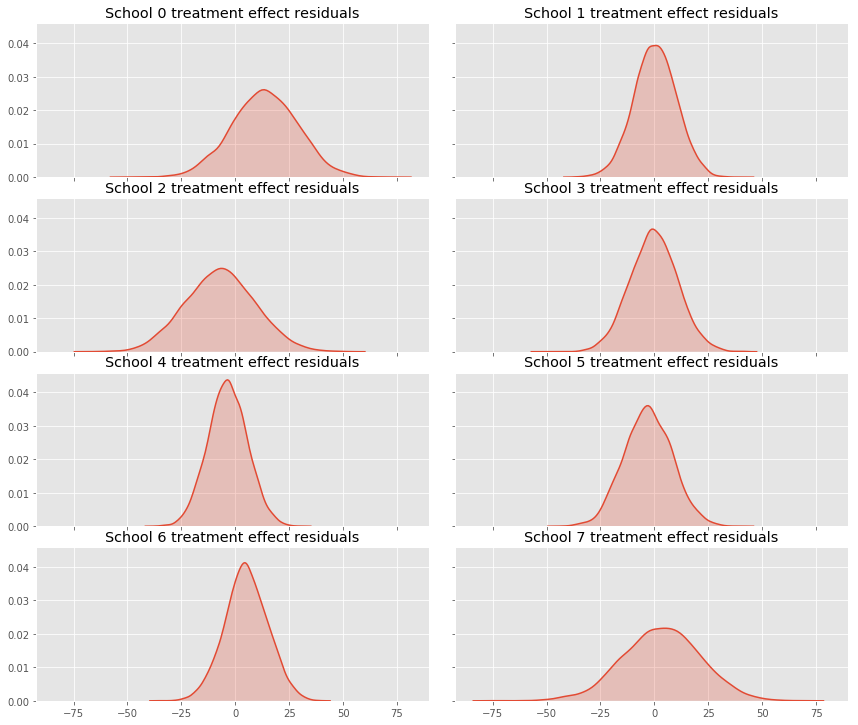

In [17]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(residuals[:, 2*i], ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect residuals".format(2*i))
  sns.kdeplot(residuals[:, 2*i + 1], ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect residuals".format(2*i + 1))
plt.show()

# Acknowledgements

This tutorial was originally written in Edward 1.0 ([source](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)). We thank all contributors to writing and revising that version.

# References
1. Donald B. Rubin. Estimation in parallel randomized experiments. Journal of Educational Statistics, 6(4):377-401, 1981.
2. Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin. Bayesian Data Analysis, Third Edition. Chapman and Hall/CRC, 2013.

In [53]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import cProfile
import functools
import os
import pstats
import time
# Dependency imports
from absl import flags
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt  # pylint: disable=g-import-not-at-top
import numpy as np
import tensorflow as tf

from tensorflow_probability import edward2 as ed
#from tensorflow_probability.experimental import no_u_turn_sampler

tfe = tf.contrib.eager

def profile(func):
  """Decorator for profiling the execution of a function."""
  @functools.wraps(func)
  def func_wrapped(*args, **kwargs):
    """Function which wraps original function with start/stop profiling."""
    pr = cProfile.Profile()
    pr.enable()
    start = time.time()
    output = func(*args, **kwargs)
    print("Elapsed", time.time() - start)
    pr.disable()
    ps = pstats.Stats(pr).sort_stats("cumulative")
    ps.print_stats()
    return output
  return func_wrapped


def logistic_regression(features):
  """Bayesian logistic regression, which returns labels given features."""
  coeffs = ed.MultivariateNormalDiag(
      loc=tf.zeros(features.shape[1]), name="coeffs")
  labels = ed.Bernoulli(
      logits=tf.tensordot(features, coeffs, [[1], [0]]), name="labels")
  return labels

features = tf.random_normal([20, 55])
labels = tf.random_uniform([20], minval=0, maxval=2, dtype=tf.int32)

log_joint = ed.make_log_joint_fn(logistic_regression)
def target_log_prob_fn(coeffs):
  return log_joint(features=features, coeffs=coeffs, labels=labels)

  # Initialize using a sample from 20 steps of NUTS. It is roughly a MAP
  # estimate and is written explicitly to avoid differences in warm-starts
  # between different implementations (e.g., Stan, PyMC3).
coeffs = tf.constant(
      [+2.03420663e+00, -3.53567265e-02, -1.49223924e-01, -3.07049364e-01,
       -1.00028366e-01, -1.46827862e-01, -1.64167881e-01, -4.20344204e-01,
       +9.47479829e-02, -1.12681836e-02, +2.64442056e-01, -1.22087866e-01,
       -6.00568838e-02, -3.79419506e-01, -1.06668741e-01, -2.97053963e-01,
       -2.05253899e-01, -4.69537191e-02, -2.78072730e-02, -1.43250525e-01,
       -6.77954629e-02, -4.34899796e-03, +5.90927452e-02, +7.23133609e-02,
       +1.38526391e-02, -1.24497898e-01, -1.50733739e-02, -2.68872194e-02,
       -1.80925727e-02, +3.47936489e-02, +4.03552800e-02, -9.98773426e-03,
       +6.20188080e-02, +1.15002751e-01, +1.32145107e-01, +2.69109547e-01,
       +2.45785132e-01, +1.19035013e-01, -2.59744357e-02, +9.94279515e-04,
       +3.39266285e-02, -1.44057125e-02, -6.95222765e-02, -7.52013028e-02,
       +1.21171586e-01, +2.29205526e-02, +1.47308692e-01, -8.34354162e-02,
       -9.34122875e-02, -2.97472421e-02, -3.03937674e-01, -1.70958012e-01,
       -1.59496680e-01, -1.88516974e-01, -1.20889175e+00])

# Initialize step size via result of 50 warmup steps from Stan.
step_size = 0.00167132

#kernel = profile(no_u_turn_sampler.kernel)
coeffs_samples = []
target_log_prob = None
grads_target_log_prob = None
for step in range(100):
    print("Step", step)
    [
        [coeffs],
        target_log_prob,
        grads_target_log_prob,
    ] = kernel(target_log_prob_fn=target_log_prob_fn,
               current_state=[coeffs],
               step_size=[step_size],
               seed=step,
               current_target_log_prob=target_log_prob,
               current_grads_target_log_prob=grads_target_log_prob)
    coeffs_samples.append(coeffs)

for coeffs_sample in coeffs_samples:
    plt.plot(coeffs_sample.numpy())

Step 0
Step 1
Step 2
Step 3


KeyboardInterrupt: 

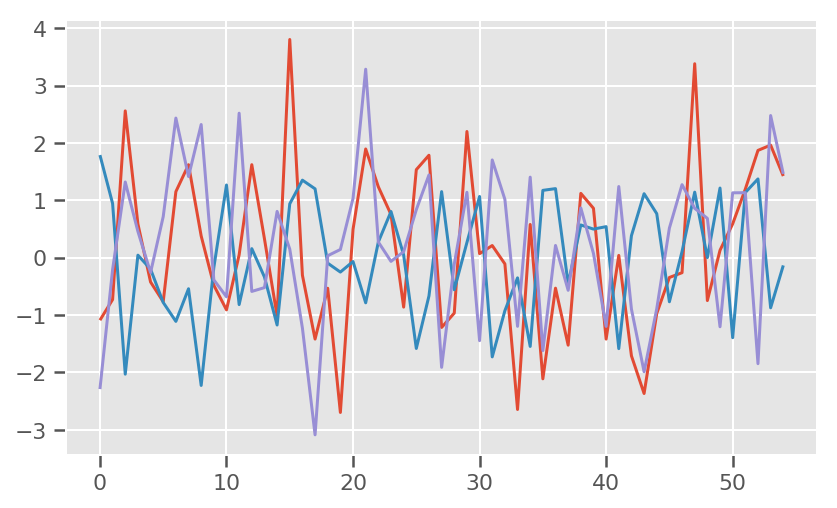

In [54]:
for coeffs_sample in coeffs_samples:
    plt.plot(coeffs_sample.numpy())

In [41]:
import pymc3 as pm

In [48]:
with pm.Model() as model:
    coeffs = pm.Normal('coeffs', 0, 1, shape=features.numpy().shape[1])
    pm.Bernoulli('labels', logit_p=pm.math.dot(features.numpy(), coeffs), observed=labels.numpy())

In [49]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coeffs]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 712.34draws/s]


In [23]:
import arviz as az

In [22]:
coeffs_samples

[<tf.Tensor: id=11909045, shape=(55,), dtype=float32, numpy=
 array([ 1.8308797 , -1.1451573 ,  0.20748849, -1.2787267 , -0.04908165,
         0.1970925 ,  0.126143  , -0.65014553, -0.42144388,  0.44558913,
         0.47715124, -0.3581137 ,  0.02135106,  0.8668571 , -0.97214824,
         0.08101579,  0.9594603 , -0.6482941 ,  1.8966619 , -0.06193538,
         0.12236879,  1.3644863 ,  0.11296485,  1.1034786 ,  0.5598541 ,
         0.19603123, -0.66834563, -0.31047088, -0.13960043,  0.02205077,
         0.5377596 ,  0.78140205, -0.41059166,  0.21934503, -0.5749163 ,
        -0.7873485 ,  0.13749418,  0.7444032 , -1.34883   ,  0.7065573 ,
        -0.1833958 , -1.1133268 , -1.3189163 , -0.9808511 ,  0.60299253,
         0.9654942 ,  0.06033953, -0.27207637, -0.02368315,  0.5223338 ,
        -1.0821148 , -0.20612222, -1.2694343 , -1.1981643 , -0.49814165],
       dtype=float32)>,
 <tf.Tensor: id=12987354, shape=(55,), dtype=float32, numpy=
 array([-1.9158942 , -0.12271304,  0.88355935,  0.